# Poetry Generator

The purpose of this notebook is to explore the power of LLM and RNN models to generate poetry from using song lyrics as a dataset. The song datasets I plan to use come from a github repo that has various lyrics from many artists written in txt files.
* https://github.com/laxmimerit/poetry-data

### Resources

This has been done before. The articles are references that I used for this notebook.

* https://kgptalkie.medium.com/poetry-generation-using-tensorflow-keras-and-lstm-75c4e4b7f07e
* https://www.kaggle.com/code/paultimothymooney/poetry-generator-rnn-markov/notebook
* https://www.kaggle.com/code/shivamb/beginners-guide-to-text-generation-using-lstms
* https://www.tensorflow.org/text/tutorials/text_generation

## Setup

Need to figure out if I'm on google colab or on local. This will determine which commands need to be ran and how to setup the CPU/GPU being used.

Additionally, if on google colab, then I will need to install my personal repository, [py-learning-toolbox](https://github.com/bkubick/py-learning-toolbox) as a package.

In [1]:
# Determining if on google colab
try:
  from google import colab
  on_colab = True
except Exception:
  on_colab = False

on_colab

False

In [2]:
# Installing my personal repo that contains all my utils as a package
if on_colab:
  !nvidia-smi -L
  !pip install py-learning-toolbox@git+https://github.com/bkubick/py-learning-toolbox.git
  !pltb_setup_project .

## Imports

In [3]:
import datetime
import logging
import random
import re
import string
import sys
import typing

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from py_learning_toolbox import ml_toolbox
from py_learning_toolbox import data_toolbox
from py_learning_toolbox import performance_toolbox
from sklearn.preprocessing import OneHotEncoder
import tensorflow as tf
import tensorflow_hub as hub

## Environment

Setting up the environment and analyzing the various information associated with this notebook.

In [4]:
print(f'Notebook last run (end-to-end): {datetime.datetime.now()}')

Notebook last run (end-to-end): 2023-10-03 19:54:33.857291


In [5]:
tf.__version__

'2.13.0'

In [6]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

In [7]:
# Setting up logging
logging.basicConfig(stream=sys.stdout, level=logging.INFO)

## Global Constants

In [8]:
RANDOM_SEED = 27

## Helpers
Defining helper functions to make split certain functionality out of tasks.

In [9]:
def download_preprocess_and_structure_data(url_by_artist: typing.Dict[str, str]) -> pd.DataFrame:
    """ Downloads and structures the data into a pandas DF.

        Args:
            url_by_artist (Dict[str, str]): the url to grab data from for the corresponding artist.

        Returns:
            (DataFrame) the corresponding structured dataframe.
    """
    all_data = []
    pattern = re.compile(r'\s+')

    for artist in url_by_artist:
        sentences = data_toolbox.read_txt_file_from_url(url_by_artist[artist], delimiter='\n')

        for sentence in sentences:
            cleaned_sentence = ml_toolbox.preprocessing.language.clean_text(sentence)

            if len(cleaned_sentence) > 0:
                all_data.append({'artist': artist, 'sentence': cleaned_sentence})

    return pd.DataFrame(all_data)

In [10]:
def generate_text(seed_text: str,
                  num_words_to_create: int,
                  model: tf.keras.models.Model,
                  one_hot: OneHotEncoder) -> str:
    """ Generates a sentence from the seed text with the designated model and encoder mapper.

        Args:
            seed_text (str): the starting text for the sentence to be generated.
            num_words_to_create (int): how many words to add.
            model (Model): the model to use to generate the text.
            one_hot (OneHotEncoder): the encoder used with the model to convert numerical indices to text.

        Returns:
            (str) the generated text.
    """
    generated_text = seed_text

    for _ in range(num_words_to_create):
        # Token + Char Embedding Inputs
        if len(model.inputs) == 2:
            generated_chars = ' '.join(list(generated_text))
            pred_probs = model.predict(x=[np.array([generated_text]), np.array([generated_chars])], verbose=0)
        else:
            pred_probs = model.predict([generated_text], verbose=0)
        pred_word_index = tf.argmax(pred_probs, axis=1)[0]
        pred_probs[0][pred_word_index] = 1  # Due to the size of the word list, rounding doesn't always gurantee a selected word
        pred_vector = tf.round(pred_probs)
        predicted_word = str(one_hot_encoder.inverse_transform(pred_vector)[0][0])
        generated_text += f' {predicted_word}'

    return generated_text

In [11]:
def generate_poem(seed_texts: typing.List[str],
                  num_words_to_create: int,
                  model: tf.keras.models.Model,
                  one_hot: OneHotEncoder) -> str:
    """ Generates a sentence from the seed texts with the designated model and encoder mapper.

        Args:
            seed_text (str): the starting text for the sentence to be generated.
            num_words_to_create (int): how many words to add.
            model (Model): the model to use to generate the text.
            one_hot (OneHotEncoder): the encoder used with the model to convert numerical indices to text.

        Returns:
            (str) the generated text.
    """
    for seed_text in seed_texts:
        print(generate_text(seed_text, num_words_to_create, model, one_hot))

## Downloading, Analyzing, & Creating Datasets

The data I plan to use comes directly from the raw txt file from the links below.

* https://github.com/laxmimerit/poetry-data

For this notebook, I am going to limit my datasets to the following artists:

* [The Beatles](https://raw.githubusercontent.com/laxmimerit/poetry-data/master/beatles.txt)
* [Adele](https://raw.githubusercontent.com/laxmimerit/poetry-data/master/adele.txt)
* [Bob Dylan](https://raw.githubusercontent.com/laxmimerit/poetry-data/master/bob-dylan.txt)
* [Disney](https://raw.githubusercontent.com/laxmimerit/poetry-data/master/disney.txt)
* [Drake](https://raw.githubusercontent.com/laxmimerit/poetry-data/master/drake.txt)
* [Dr. Seuss](https://raw.githubusercontent.com/laxmimerit/poetry-data/master/dr-seuss.txt)

### Constants

In [12]:
DATA_URLS = {
    'beatles': 'https://raw.githubusercontent.com/laxmimerit/poetry-data/master/beatles.txt',
    'adele': 'https://raw.githubusercontent.com/laxmimerit/poetry-data/master/adele.txt',
    'bob_dylan': 'https://raw.githubusercontent.com/laxmimerit/poetry-data/master/bob-dylan.txt',
    # 'disney': 'https://raw.githubusercontent.com/laxmimerit/poetry-data/master/disney.txt',
    # 'drake': 'https://raw.githubusercontent.com/laxmimerit/poetry-data/master/drake.txt',
    # 'dr_seuss': 'https://raw.githubusercontent.com/laxmimerit/poetry-data/master/dr-seuss.txt',
}

### Downloading & Analyzing Data

In [13]:
data_df = download_preprocess_and_structure_data(DATA_URLS)
data_df

,artist,sentence
0,beatles,yesterday all my troubles seemed so far away
1,beatles,now it looks as though theyre here to stay
2,beatles,oh i believe in yesterday suddenly im not half...
3,beatles,theres a shadow hanging over me
4,beatles,oh yesterday came suddenly why she had to go i...
...,...,...
9454,bob_dylan,shine your light shine your light on me
9455,bob_dylan,shine your light shine your light on me
9456,bob_dylan,shine your light shine your light on me
9457,bob_dylan,ya know i just couldn’t make it by myself


In [14]:
sentences = data_df.sentence.to_numpy()
sentences[:5]

array(['yesterday all my troubles seemed so far away',
       'now it looks as though theyre here to stay',
       'oh i believe in yesterday suddenly im not half the man i used to be',
       'theres a shadow hanging over me',
       'oh yesterday came suddenly why she had to go i dont know she wouldnt say'],
      dtype=object)

In [15]:
sentences[-5:]

array(['shine your light shine your light on me',
       'shine your light shine your light on me',
       'shine your light shine your light on me',
       'ya know i just couldn’t make it by myself',
       'i’m a little too blind to see'], dtype=object)

In [16]:
# Seeing the vocab
word_counts = ml_toolbox.analysis.language.get_word_counts(sentences)

len(word_counts)

5683

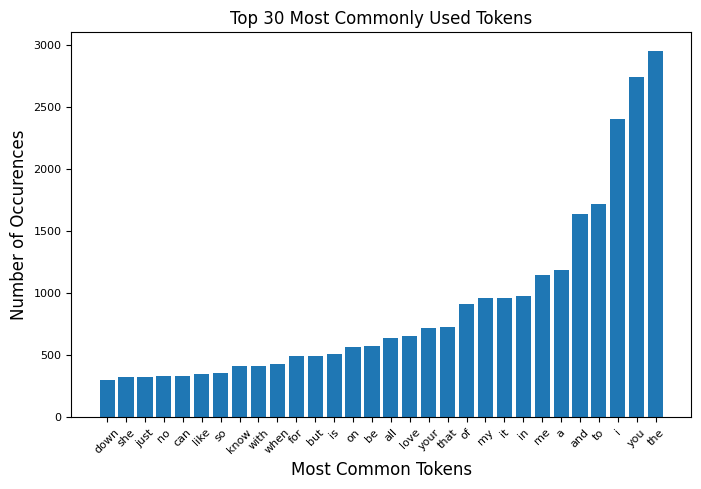

In [17]:
ml_toolbox.analysis.language.plot_token_counts(word_counts, most_common=True, n=30)

In [18]:
# Seeing the Characters
character_counts = ml_toolbox.analysis.language.get_character_counts(sentences)

len(character_counts)

41

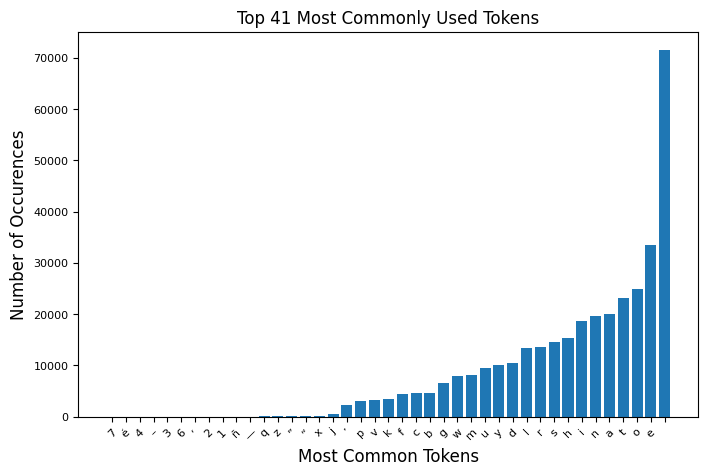

In [19]:
ml_toolbox.analysis.language.plot_token_counts(character_counts, most_common=True, n=41)

### Creating Training Data

In [20]:
X, y = ml_toolbox.preprocessing.language.create_sequenced_data_labels_from_sentences(sentences)
X[:3], y[:3]

(['yesterday', 'yesterday all', 'yesterday all my'], ['all', 'my', 'troubles'])

In [21]:
X_char = [' '.join(list(sentence)) for sentence in X]
X_char[:3]

['y e s t e r d a y',
 'y e s t e r d a y   a l l',
 'y e s t e r d a y   a l l   m y']

In [22]:
one_hot_encoder = OneHotEncoder(sparse_output=False)
one_hot_encoder.fit_transform(np.array(list(word_counts)).reshape((-1,1)))

y_one_hot_encoded = one_hot_encoder.transform(np.array(y).reshape((-1,1)))

y_one_hot_encoded.shape

(62035, 5683)

### Creating Datasets

In [23]:
train_dataset = data_toolbox.datasets.generate_dataset_from_data([X], y_one_hot_encoded)
train_dataset

<_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None),), TensorSpec(shape=(None, 5683), dtype=tf.float64, name=None))>

In [24]:
char_train_dataset = data_toolbox.datasets.generate_dataset_from_data([X_char], y_one_hot_encoded)
char_train_dataset

<_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None),), TensorSpec(shape=(None, 5683), dtype=tf.float64, name=None))>

## Experiments

I am going to run a handful of experiments to try and generate poems, as listed below:

* Experiment-0 (Baseline): LSTM w/ Token Embeddings
* Experiment-1: Universal Sentence Encoder w/ Token Embeddings
* Experiment-2: Conv1D w/ Token Embeddings
* Experiment-3: Bidirectional LSTM w/ Token Embeddings
* Experiment-4: LSTM w/ Character Embeddings
* Experiment-5: LSTM w/ Token Embeddings + Character Embeddings

### Constants

In [25]:
TOTAL_WORDS = len(word_counts)
TOTAL_CHARS = len(character_counts)

UNIVERSAL_SENTENCE_ENCODER_URL = 'https://tfhub.dev/google/universal-sentence-encoder/4'

TEST_SEED_TEXTS = [
    'Love is true',
    'Tomorrow comes',
    'Yesterday we',
    'But today',
]

### Preprocessing Layer Setup

Many embedding layers will be reused for more than one of the experiments mentioned above. These steps will setup the layers to be used in experiments such that they can be reused for multiple models. The various layers to be made are:

* `text_vectorizer` (TextVectorizer)
* `token_embedding` (Embedding)
* `character_vectorizer` (TextVectorizer)
* `character_embeddings` (Embedding)

#### Token Embeddings

In [26]:
# Find average number of tokens
sent_lens = [len(sentence.split()) for sentence in sentences]
round(sum(sent_lens) / len(sentences))

8

In [27]:
max(sent_lens)

34

In [28]:
# How long of a sentence covers 98% of the examples?
int(np.percentile(sent_lens, 98))

16

In [29]:
# Setup text vectorization params
max_vocab_length = 10000  # Max words to have in our vocab
max_length = 16

In [30]:
# Setting up a text vectorization layer (tokenization)
text_vectorizer = tf.keras.layers.experimental.preprocessing.TextVectorization(
    max_tokens=max_vocab_length,  # How many words in the vocabulary
    output_sequence_length=max_length)  # Padds (adds 0's to end of number) to make all the same length

# Adapt the vectorizer to the training data
text_vectorizer.adapt(sentences)

In [31]:
# Getting the words in the vocab from the training data
words_in_vocab = text_vectorizer.get_vocabulary()
top_5_words = words_in_vocab[:5]
least_common_5_words = words_in_vocab[-5:]

len(words_in_vocab), top_5_words, least_common_5_words

(5685,
 ['', '[UNK]', 'the', 'you', 'i'],
 ['abel', 'abeatin’', 'abandon', 'aaaaahhhhhhhhhh', '61”'])

In [32]:
# Setting up the Embedding layer
token_embedding = tf.keras.layers.Embedding(input_dim=len(words_in_vocab),
                                            output_dim=128,  # GPU's work well when number is divisible by 8
                                            mask_zero=True,
                                            name='token_embedding')
token_embedding

In [33]:
# Testing out an example sentence
target_sentence = random.choice(sentences)

# Looking at the steps of tokenization
print(f'Sentence before vectorization: \n {target_sentence}')
vectorized_sentence = text_vectorizer([target_sentence])
print(f'Sentence after vectorization: \n {vectorized_sentence}')
embedded_sentence = token_embedding(vectorized_sentence)
print(f'Sentence after embedding: \n {embedded_sentence}')
print(f'Embedded sentence shape: {embedded_sentence.shape}')

Sentence before vectorization: 
 i got love for you and it’s all in vain
Sentence after vectorization: 
 [[   4   59   15   21    3    6   81   16    9 1200    0    0    0    0
     0    0]]
Sentence after embedding: 
 [[[-0.04708974  0.04398698  0.01212256 ... -0.0375194   0.02955911
   -0.03256111]
  [ 0.00651488  0.02822507  0.04447111 ... -0.02238019  0.03522925
    0.02479471]
  [ 0.00696265 -0.0403204  -0.00881221 ... -0.03205519 -0.00758789
   -0.02047867]
  ...
  [ 0.04103691  0.00764495  0.04050635 ...  0.03271897  0.03668577
   -0.0025274 ]
  [ 0.04103691  0.00764495  0.04050635 ...  0.03271897  0.03668577
   -0.0025274 ]
  [ 0.04103691  0.00764495  0.04050635 ...  0.03271897  0.03668577
   -0.0025274 ]]]
Embedded sentence shape: (1, 16, 128)


#### Character Embeddings

In [34]:
# Find average number of tokens
char_lens = [len(sentence) for sentence in sentences]
round(sum(char_lens) / len(sentences))

36

In [35]:
max(char_lens)

150

In [36]:
# How long of a sentence covers 98% of the examples?
output_sequence_len = int(np.percentile(char_lens, 98))
output_sequence_len

76

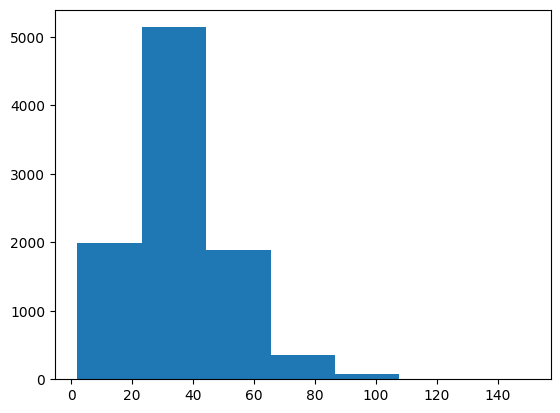

In [37]:
plt.hist(char_lens, bins=7);

In [38]:
# Figuring out the total alpha-numeric characters
alphabet = string.ascii_lowercase + string.digits + string.punctuation

alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [39]:
NUM_CHAR_TOKENS = len(alphabet) + 2  # Add 2 for space and OOV token ([UNK])
NUM_CHAR_TOKENS

70

In [40]:
# Setting up a text vectorization layer (tokenization)
character_vectorizer = tf.keras.layers.experimental.preprocessing.TextVectorization(
    max_tokens=NUM_CHAR_TOKENS,
    output_sequence_length=output_sequence_len,
    name='char_vectorizer')

# Adapt the vectorizer to the training data
character_vectorizer.adapt(X_char)

In [41]:
char_vocab = character_vectorizer.get_vocabulary()
print(f'Number of Different Characters: {len(char_vocab)}')
print(f'5 Most Common Characters: {char_vocab[:5]}')
print(f'5 Least Common Characters: {char_vocab[-5:]}')

Number of Different Characters: 41
5 Most Common Characters: ['', '[UNK]', 'e', 't', 'o']
5 Least Common Characters: ['2', '3', '7', '4', 'é']


In [42]:
character_embedding = tf.keras.layers.Embedding(input_dim=len(char_vocab),
                                                output_dim=25,
                                                mask_zero=True,
                                                name='character_embedding')
character_embedding

In [43]:
# Testing out an example sentence
target_chars = random.choice(X_char)

# Looking at the steps of tokenization
print(f'Chars before vectorization: \n {target_chars}')

vectorized_chars = character_vectorizer([target_chars])
print(f'Chars after vectorization: \n {vectorized_chars}')
embedded_chars = character_embedding(vectorized_chars)
print(f'Chars after embedding: \n {embedded_chars}')
print(f'Embedded chars shape: {embedded_chars.shape}')

Chars before vectorization: 
 e v e r y t h i n g   h a s   g o t   t o
Chars after vectorization: 
 [[ 2 22  2 11 12  3  8  6  7 17  8  5  9 17  4  3  3  4  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0]]
Chars after embedding: 
 [[[ 0.00152189  0.00632749  0.02617245 ...  0.03745938 -0.02925341
    0.04378598]
  [ 0.02846709 -0.04614455 -0.03469554 ... -0.00123985 -0.02151176
   -0.01001065]
  [ 0.00152189  0.00632749  0.02617245 ...  0.03745938 -0.02925341
    0.04378598]
  ...
  [ 0.01312682 -0.01458179 -0.00888576 ...  0.02030304 -0.01114457
   -0.04373753]
  [ 0.01312682 -0.01458179 -0.00888576 ...  0.02030304 -0.01114457
   -0.04373753]
  [ 0.01312682 -0.01458179 -0.00888576 ...  0.02030304 -0.01114457
   -0.04373753]]]
Embedded chars shape: (1, 76, 25)


### Experiment-0 (Baseline): LSTM with Token Embeddings

For a baseline, going to use a very simple model with only a single LSTM layer.

In [44]:
# Constants
model_0_name = 'model_0_simple_lstm'

In [45]:
inputs = tf.keras.layers.Input(shape=(1,), dtype=tf.string)

x = text_vectorizer(inputs)  # Turn the input text into numbers
x = token_embedding(x)  # Embed the text
x = tf.keras.layers.LSTM(64)(x)

outputs = tf.keras.layers.Dense(TOTAL_WORDS, activation='softmax')(x)

model_0 = tf.keras.models.Model(inputs, outputs, name=model_0_name)
model_0.summary()

Model: "model_0_simple_lstm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 16)                0         
 ctorization)                                                    
                                                                 
 token_embedding (Embedding  (None, 16, 128)           727680    
 )                                                               
                                                                 
 lstm (LSTM)                 (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 5683)              369395    
                                                                 
Total params: 1146483 (4.37 MB)
Trainable param

In [46]:
model_0.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.legacy.Adam(),
                metrics=['accuracy'])

In [47]:
model_0.fit(train_dataset, epochs=10)

Epoch 1/10
1939/1939 [==============================] - 23s 11ms/step - loss: 6.6860 - accuracy: 0.0471
Epoch 2/10
1939/1939 [==============================] - 22s 12ms/step - loss: 5.9944 - accuracy: 0.0635
Epoch 3/10
1939/1939 [==============================] - 23s 12ms/step - loss: 5.5819 - accuracy: 0.0916
Epoch 4/10
1939/1939 [==============================] - 23s 12ms/step - loss: 5.2355 - accuracy: 0.1147
Epoch 5/10
1939/1939 [==============================] - 24s 12ms/step - loss: 4.9181 - accuracy: 0.1406
Epoch 6/10
1939/1939 [==============================] - 23s 12ms/step - loss: 4.6344 - accuracy: 0.1689
Epoch 7/10
1939/1939 [==============================] - 25s 13ms/step - loss: 4.3755 - accuracy: 0.1979
Epoch 8/10
1939/1939 [==============================] - 24s 12ms/step - loss: 4.1450 - accuracy: 0.2287
Epoch 9/10
1939/1939 [==============================] - 24s 12ms/step - loss: 3.9310 - accuracy: 0.2580
Epoch 10/10
1939/1939 [==============================] - 25s 13m

In [48]:
generate_poem(TEST_SEED_TEXTS, 8, model_0, one_hot_encoder)

Love is true love you love you love you love you
Tomorrow comes around the bend that he said they couldn’t
Yesterday we can be the thief to me with you
But today was a million miles from you to the


### Experiment-1: Universal Sentence Encoder with Token Embeddings

In [49]:
# Constants
model_1_name = 'model_1_use'

In [50]:
# Build Model
inputs = tf.keras.layers.Input(shape=[], dtype=tf.string)
pretrained_embedding = hub.KerasLayer(UNIVERSAL_SENTENCE_ENCODER_URL,
                                      trainable=False,
                                      name='USE')(inputs)
x = tf.keras.layers.Dense(128, activation='relu')(pretrained_embedding)
outputs = tf.keras.layers.Dense(TOTAL_WORDS, activation='softmax')(x)

model_1 = tf.keras.models.Model(inputs, outputs, name=model_1_name)
model_1.summary()

INFO:absl:Using /var/folders/sj/rsg548nx63dc931tmwt4nnq80000gn/T/tfhub_modules to cache modules.
INFO:absl:Fingerprint not found. Saved model loading will continue.
Model: "model_1_use"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None,)]                 0         
                                                                 
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dense_2 (Dense)             (None, 5683)              733107    
                                                                 
Total params: 257596595 (982.65 MB)
Trainable params: 798771 (3.05 MB)
Non-trainable params: 256797824 (979.61 MB)
_______________________________________

In [51]:
model_1.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.legacy.Adam(),
                metrics=['accuracy'])

In [52]:
model_1.fit(train_dataset, epochs=10)

Epoch 1/10
1939/1939 [==============================] - 9s 4ms/step - loss: 6.6337 - accuracy: 0.0533
Epoch 2/10
1939/1939 [==============================] - 8s 4ms/step - loss: 5.9573 - accuracy: 0.0676
Epoch 3/10
1939/1939 [==============================] - 8s 4ms/step - loss: 5.5928 - accuracy: 0.0794
Epoch 4/10
1939/1939 [==============================] - 8s 4ms/step - loss: 5.2186 - accuracy: 0.0934
Epoch 5/10
1939/1939 [==============================] - 8s 4ms/step - loss: 4.8324 - accuracy: 0.1132
Epoch 6/10
1939/1939 [==============================] - 8s 4ms/step - loss: 4.4521 - accuracy: 0.1429
Epoch 7/10
1939/1939 [==============================] - 9s 4ms/step - loss: 4.1151 - accuracy: 0.1747
Epoch 8/10
1939/1939 [==============================] - 8s 4ms/step - loss: 3.8372 - accuracy: 0.2093
Epoch 9/10
1939/1939 [==============================] - 8s 4ms/step - loss: 3.6125 - accuracy: 0.2464
Epoch 10/10
1939/1939 [==============================] - 9s 4ms/step - loss: 3.432

In [53]:
generate_poem(TEST_SEED_TEXTS, 8, model_1, one_hot_encoder)

Love is true in evil and neither or the neither the
Tomorrow comes mercy the the the the sun on the
Yesterday we suddenly i ago i i i grew gone
But today the sun shining is tonight is the the


### Experiment-2: Conv1D with Token Embeddings

In [54]:
# Constants
model_2_name = 'model_2_conv1d_token'

In [55]:
# Build Model
inputs = tf.keras.layers.Input(shape=(1,), dtype=tf.string)

text_vectors = text_vectorizer(inputs)
token_embeddings = token_embedding(text_vectors)
x = tf.keras.layers.Conv1D(filters=64, kernel_size=5, activation='relu', padding='same')(token_embeddings)
x = tf.keras.layers.GlobalMaxPooling1D()(x)

outputs = tf.keras.layers.Dense(TOTAL_WORDS, activation='softmax')(x)

model_2 = tf.keras.models.Model(inputs, outputs, name=model_2_name)
model_2.summary()

Model: "model_2_conv1d_token"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 16)                0         
 ctorization)                                                    
                                                                 
 token_embedding (Embedding  (None, 16, 128)           727680    
 )                                                               
                                                                 
 conv1d (Conv1D)             (None, 16, 64)            41024     
                                                                 
 global_max_pooling1d (Glob  (None, 64)                0         
 alMaxPooling1D)                                                 
                                              

In [56]:
model_2.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.legacy.Adam(),
                metrics=['accuracy'])

In [57]:
model_2.fit(train_dataset, epochs=10)

Epoch 1/10
1939/1939 [==============================] - 11s 6ms/step - loss: 6.3430 - accuracy: 0.0775
Epoch 2/10
1939/1939 [==============================] - 12s 6ms/step - loss: 5.3956 - accuracy: 0.1293
Epoch 3/10
1939/1939 [==============================] - 12s 6ms/step - loss: 4.9122 - accuracy: 0.1607
Epoch 4/10
1939/1939 [==============================] - 12s 6ms/step - loss: 4.5052 - accuracy: 0.1951
Epoch 5/10
1939/1939 [==============================] - 12s 6ms/step - loss: 4.1320 - accuracy: 0.2281
Epoch 6/10
1939/1939 [==============================] - 12s 6ms/step - loss: 3.7841 - accuracy: 0.2687
Epoch 7/10
1939/1939 [==============================] - 12s 6ms/step - loss: 3.4773 - accuracy: 0.3059
Epoch 8/10
1939/1939 [==============================] - 13s 7ms/step - loss: 3.2135 - accuracy: 0.3418
Epoch 9/10
1939/1939 [==============================] - 12s 6ms/step - loss: 2.9872 - accuracy: 0.3754
Epoch 10/10
1939/1939 [==============================] - 12s 6ms/step - l

In [58]:
generate_poem(TEST_SEED_TEXTS, 8, model_2, one_hot_encoder)

Love is true love is all right of mississippi a day
Tomorrow comes comin’ the man of the little thing of
Yesterday we need a shot of love i need a
But today gets walkin in the sky of blue new


### Experiment-3: Bidirectional LSTM with Token Embeddings

In [59]:
# Constants
model_3_name = 'model_3_bidirectional_lstm'

In [60]:
inputs = tf.keras.layers.Input(shape=(1,), dtype=tf.string)

x = text_vectorizer(inputs)  # Turn the input text into numbers
x = token_embedding(x)  # Embed the text
x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64))(x)

outputs = tf.keras.layers.Dense(TOTAL_WORDS, activation='softmax')(x)

model_3 = tf.keras.models.Model(inputs, outputs, name=model_3_name)
model_3.summary()

Model: "model_3_bidirectional_lstm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 16)                0         
 ctorization)                                                    
                                                                 
 token_embedding (Embedding  (None, 16, 128)           727680    
 )                                                               
                                                                 
 bidirectional (Bidirection  (None, 128)               98816     
 al)                                                             
                                                                 
 dense_4 (Dense)             (None, 5683)              733107    
                                        

In [61]:
model_3.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.legacy.Adam(),
                metrics=['accuracy'])

In [62]:
model_3.fit(train_dataset, epochs=10)

Epoch 1/10
1939/1939 [==============================] - 27s 12ms/step - loss: 6.1286 - accuracy: 0.0921
Epoch 2/10
1939/1939 [==============================] - 23s 12ms/step - loss: 5.0347 - accuracy: 0.1573
Epoch 3/10
1939/1939 [==============================] - 23s 12ms/step - loss: 4.4067 - accuracy: 0.2131
Epoch 4/10
1939/1939 [==============================] - 24s 12ms/step - loss: 3.9146 - accuracy: 0.2638
Epoch 5/10
1939/1939 [==============================] - 24s 12ms/step - loss: 3.5099 - accuracy: 0.3162
Epoch 6/10
1939/1939 [==============================] - 23s 12ms/step - loss: 3.1709 - accuracy: 0.3661
Epoch 7/10
1939/1939 [==============================] - 23s 12ms/step - loss: 2.8791 - accuracy: 0.4141
Epoch 8/10
1939/1939 [==============================] - 23s 12ms/step - loss: 2.6367 - accuracy: 0.4569
Epoch 9/10
1939/1939 [==============================] - 23s 12ms/step - loss: 2.4321 - accuracy: 0.4932
Epoch 10/10
1939/1939 [==============================] - 23s 12m

In [63]:
generate_poem(TEST_SEED_TEXTS, 8, model_3, one_hot_encoder)

Love is true love is it all that i can be
Tomorrow comes on the line make it out to come
Yesterday we have been don pasqualli makin’ a little boy
But today were never true never true never true never


### Experiment-4: LSTM with Character Embeddings

In [64]:
# Constants
model_4_name = 'model_4_lstm_char'

In [65]:
inputs = tf.keras.layers.Input(shape=(1,), dtype=tf.string)

x = character_vectorizer(inputs)  # Turn the input text into numbers
x = character_embedding(x)  # Embed the text
x = tf.keras.layers.LSTM(64)(x)

outputs = tf.keras.layers.Dense(TOTAL_WORDS, activation='softmax')(x)

model_4 = tf.keras.models.Model(inputs, outputs, name=model_4_name)
model_4.summary()

Model: "model_4_lstm_char"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVecto  (None, 76)                0         
 rization)                                                       
                                                                 
 character_embedding (Embed  (None, 76, 25)            1025      
 ding)                                                           
                                                                 
 lstm_2 (LSTM)               (None, 64)                23040     
                                                                 
 dense_5 (Dense)             (None, 5683)              369395    
                                                                 
Total params: 393460 (1.50 MB)
Trainable params: 

In [66]:
model_4.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.legacy.Adam(),
                metrics=['accuracy'])

In [67]:
model_4.fit(char_train_dataset, epochs=10)

Epoch 1/10
1939/1939 [==============================] - 40s 20ms/step - loss: 6.7091 - accuracy: 0.0458
Epoch 2/10
1939/1939 [==============================] - 39s 20ms/step - loss: 6.3537 - accuracy: 0.0477
Epoch 3/10
1939/1939 [==============================] - 39s 20ms/step - loss: 6.2395 - accuracy: 0.0487
Epoch 4/10
1939/1939 [==============================] - 39s 20ms/step - loss: 6.0474 - accuracy: 0.0536
Epoch 5/10
1939/1939 [==============================] - 39s 20ms/step - loss: 5.8232 - accuracy: 0.0593
Epoch 6/10
1939/1939 [==============================] - 39s 20ms/step - loss: 5.6163 - accuracy: 0.0676
Epoch 7/10
1939/1939 [==============================] - 39s 20ms/step - loss: 5.4207 - accuracy: 0.0757
Epoch 8/10
1939/1939 [==============================] - 39s 20ms/step - loss: 5.2568 - accuracy: 0.0806
Epoch 9/10
1939/1939 [==============================] - 39s 20ms/step - loss: 5.1192 - accuracy: 0.0890
Epoch 10/10
1939/1939 [==============================] - 39s 20m

In [68]:
generate_poem(TEST_SEED_TEXTS, 8, model_4, one_hot_encoder)

Love is true to to to to to to to to
Tomorrow comes the to to to to to to to
Yesterday we the to to to to to to to
But today the to to to to to to to


### Experiment-5: LSTM with Character Embeddings & Token Embeddings

In [69]:
# Constants
model_5_name = 'model_5_lstm_char_token'

In [70]:
# Creating Dataset
token_char_dataset = data_toolbox.generate_dataset_from_data([X, X_char], y_one_hot_encoded)
token_char_dataset

<_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5683), dtype=tf.float64, name=None))>

In [71]:
# Token Embedding
token_inputs = tf.keras.layers.Input(shape=(1,), dtype=tf.string)

x = text_vectorizer(token_inputs)  # Turn the input text into numbers
x = token_embedding(x)  # Embed the text
token_lstm = tf.keras.layers.LSTM(64)(x)

token_model = tf.keras.models.Model(token_inputs, token_lstm, name=model_5_name)

# Character Embedding
character_inputs = tf.keras.layers.Input(shape=(1,), dtype=tf.string)

x = character_vectorizer(character_inputs)  # Turn the input text into numbers
x = character_embedding(x)  # Embed the text
char_lstm = tf.keras.layers.LSTM(64)(x)

character_model = tf.keras.models.Model(character_inputs, char_lstm, name=model_5_name)

# Concatenating outputs
token_char_concat = tf.keras.layers.Concatenate()([token_model.output, character_model.output])

# Dropout
combined_dropout = tf.keras.layers.Dropout(0.5)(token_char_concat)
combined_dense = tf.keras.layers.Dense(128, activation='relu')(combined_dropout)
final_dropout = tf.keras.layers.Dropout(0.5)(combined_dense)

outputs = tf.keras.layers.Dense(TOTAL_WORDS, activation='softmax')(final_dropout)

model_5 = tf.keras.models.Model(inputs=[token_model.input, character_model.input],
                                outputs=outputs,
                                name=model_5_name)
model_5.summary()

Model: "model_5_lstm_char_token"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 input_7 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 text_vectorization (TextVe  (None, 16)                   0         ['input_6[0][0]']             
 ctorization)                                                                                     
                                                                                                  
 char_vectorizer (TextVecto  (None, 76)                   0         ['input_

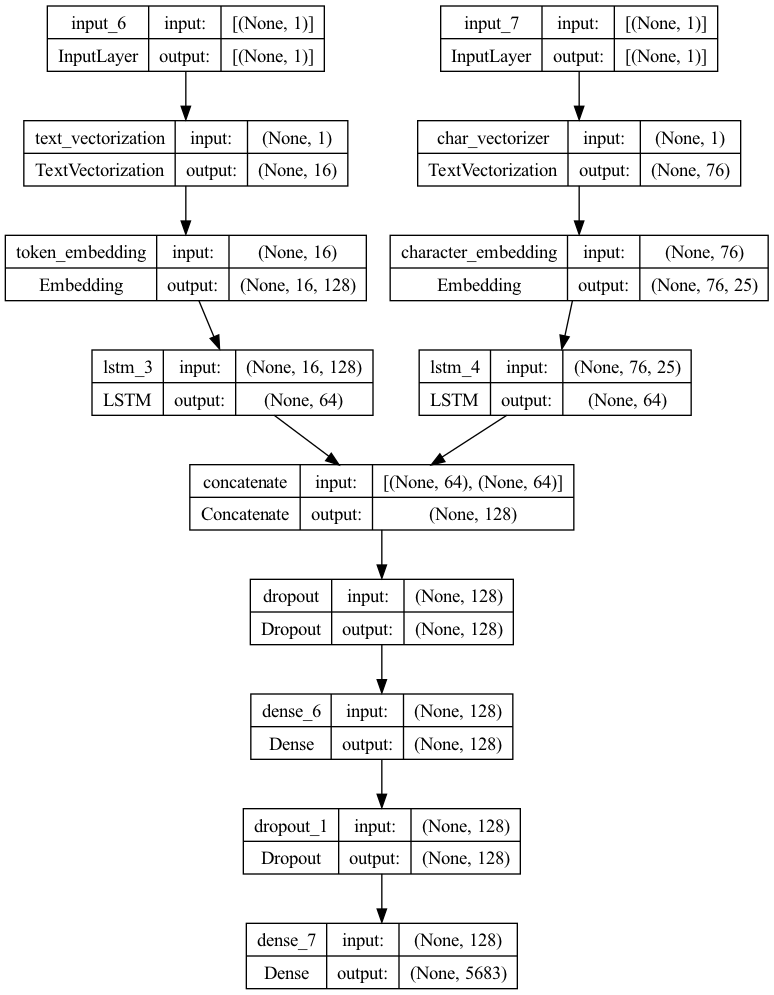

In [72]:
ml_toolbox.analysis.model.plot_model(model_5)

In [73]:
model_5.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.legacy.Adam(),
                metrics=['accuracy'])

In [74]:
model_5.fit(token_char_dataset, epochs=10)

Epoch 1/10
1939/1939 [==============================] - 44s 21ms/step - loss: 6.4294 - accuracy: 0.0670
Epoch 2/10
1939/1939 [==============================] - 41s 21ms/step - loss: 5.7583 - accuracy: 0.1039
Epoch 3/10
1939/1939 [==============================] - 41s 21ms/step - loss: 5.4895 - accuracy: 0.1240
Epoch 4/10
1939/1939 [==============================] - 42s 22ms/step - loss: 5.2956 - accuracy: 0.1365
Epoch 5/10
1939/1939 [==============================] - 42s 22ms/step - loss: 5.1400 - accuracy: 0.1470
Epoch 6/10
1939/1939 [==============================] - 42s 22ms/step - loss: 5.0089 - accuracy: 0.1533
Epoch 7/10
1939/1939 [==============================] - 42s 21ms/step - loss: 4.9041 - accuracy: 0.1606
Epoch 8/10
1939/1939 [==============================] - 42s 22ms/step - loss: 4.8194 - accuracy: 0.1651
Epoch 9/10
1939/1939 [==============================] - 42s 22ms/step - loss: 4.7420 - accuracy: 0.1701
Epoch 10/10
1939/1939 [==============================] - 42s 22m

In [75]:
generate_poem(TEST_SEED_TEXTS, 8, model_5, one_hot_encoder)

Love is true love i can be the world is a
Tomorrow comes the world is the road is the world
Yesterday we know i can be the world is the
But today was a woman to be the road is
